In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import matplotlib.pyplot as plt
import pickle
import mygene
from os import path
# mg = mygene.MyGeneInfo()


import scipy.sparse
import scipy.io

In [2]:
def make_raw_dataset(samples, path, name):
    """
    Function to load, preprocess and concatenate a dataset from multiple RNAseq
     samples
    Inputs:
     samples, dictionary of sample file prefixes as keys and timepoint metadata
      as values
     path, path to directory containing sample files
     name, dataset name for labeling AnnData object metadata
    Output: AnnData object of concatenated samples, annotated with dataset,
     timepoint, and sample id labels
    """
    anndata_dict = {}

    for sm in samples.keys():
        print(sm)

        # read in data from GEO file
        data = sc.read_10x_mtx(path, prefix=sm, cache=True)

        # add metadata information
        data.obs['dataset'] = name
        data.obs['timepoint'] = samples[sm]

        # add to dict for concatenation
        anndata_dict[sm] = data

    # concatenate samples
    data_full = ad.concat(anndata_dict, join='outer', label='sample id', index_unique='_', fill_value=0.0)
    return data_full


def make_all_raw_datasets(samples, paths, names, meta):
    """
    reads all datasets and performs integration
    :param samples: list of samples
    :param paths: list of paths
    :param names: list of names
    :param meta: list of metadata locations
    :return:
    """
    datasets = []
    for i in range(len(meta)):
        # make raw datsets using helper functions
        if meta[i] is None:
            dataset = make_raw_dataset(samples[i], paths[i], names[i])
            sc.pp.filter_genes(dataset, min_cells=10)
            run_normalization(dataset, n_top_genes=10000)
            datasets.append(dataset)
     
    # concatenate data
    all_data = ad.concat(datasets, join='outer', label='sample id', index_unique='_', fill_value=0.0)

    # run harmony
    run_harmony_integration(all_data, normalize=False)

    # save data to reduce computation time
    with open('all_integrated', 'wb') as f:
        pickle.dump(all_data, f)

    datasets_integrated = []
    for name in names:
        dataset_int = all_data[np.equal(all_data.obs['dataset'], name), :]
        name_str =  name + '_integrated'
        with open(name_str, 'wb') as f:
            pickle.dump(dataset_int, f)
        datasets_integrated.append(dataset_int)
    return all_data, datasets_integrated


def run_normalization(dataset, n_top_genes=None, plot=False):
    """
    Runs normalization and filtering based on zheng17 paper
    :param dataset: AnnData dataset
    :return: filtered dataset
    """

    norm_data = sc.pp.recipe_zheng17(dataset,
                                     n_top_genes=n_top_genes,
                                     log=True,
                                     plot=plot)
    return norm_data


def run_harmony_integration(dataset, normalize=True):
    """
    Runs harmony integration and return dataframe
    :param dataset: anndata dataset to analyze
    :return: pandas dataframe with principal components and
    modified principal components
    """
    if normalize:
        run_normalization(dataset)
    sc.tl.pca(dataset)
    sce.pp.harmony_integrate(dataset, 'dataset')
    result_df = dataset.obsm.to_df()
    result_df['Sample ID'] = dataset.obs['sample id']
    ids = list(set(dataset.obs['sample id']))
    id_map = [(ids[i], i) for i in range(len(ids))]
    id_map = dict(id_map)
    result_df['color'] = [id_map[idx] for idx in dataset.obs['sample id']]
    return result_df

In [3]:
samples_by_day = {
    'GSM2836267_D0.': 'D0',
#     'GSM2836268_D2-1.': 'D2',
#     'GSM2836269_D2-2.': 'D2',
#     'GSM2836270_D4-1.': 'D4',
#     'GSM2836271_D4-2.': 'D4',
#     'GSM2836272_D6-1.': 'D6',
#     'GSM2836273_D6-2.': 'D6',
#     'GSM2836274_D8-1.': 'D8',
#     'GSM2836275_D8-2.': 'D8',
#     'GSM2836276_D9-1-2i.': 'D9',
#     'GSM2836277_D9-2-2i.': 'D9',
#     'GSM2836278_D10-1-2i.': 'D10',
#     'GSM2836279_D10-2-2i.': 'D10',
#     'GSM2836280_D11-2i.': 'D11',
#     'GSM2836281_D12-1-2i.': 'D12',
#     'GSM2836282_D12-2-2i.': 'D12',
#     'GSM2836283_D16-2i.': 'D16',
    'GSM2836284_iPSCs-2i.': 'iPSCs',
}

SAMPLES = [samples_by_day]
PATHS = ['./raw']#  ['Data/Shiebinger/GSE106340_RAW/']
NAMES = ['shiebinger']
META = [None]

all_data, all_sets = make_all_raw_datasets(SAMPLES, PATHS, NAMES, META)

GSM2836267_D0.
GSM2836284_iPSCs-2i.


2022-04-12 16:31:08,675 - harmonypy - INFO - Iteration 1 of 10
2022-04-12 16:31:09,956 - harmonypy - INFO - Iteration 2 of 10
2022-04-12 16:31:11,167 - harmonypy - INFO - Iteration 3 of 10
2022-04-12 16:31:12,375 - harmonypy - INFO - Iteration 4 of 10
2022-04-12 16:31:13,669 - harmonypy - INFO - Iteration 5 of 10
2022-04-12 16:31:14,146 - harmonypy - INFO - Converged after 5 iterations
/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/ipykernel_launcher.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [4]:
all_sets

[View of AnnData object with n_obs × n_vars = 7158 × 9999
     obs: 'dataset', 'timepoint', 'sample id', 'n_counts_all'
     uns: 'pca'
     obsm: 'X_pca', 'X_pca_harmony'
     varm: 'PCs']

In [ ]:
d0_d18_all_data_to_df = 

In [5]:
all_data

AnnData object with n_obs × n_vars = 7158 × 9999
    obs: 'dataset', 'timepoint', 'sample id', 'n_counts_all'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [39]:
all_data

AnnData object with n_obs × n_vars = 4241 × 9999
    obs: 'dataset', 'timepoint', 'sample id', 'n_counts_all'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [40]:
all_sets

[View of AnnData object with n_obs × n_vars = 4241 × 9999
     obs: 'dataset', 'timepoint', 'sample id', 'n_counts_all'
     uns: 'pca'
     obsm: 'X_pca', 'X_pca_harmony'
     varm: 'PCs']

In [50]:
all_data_df = all_data.to_df()
all_data_df

,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,Fam150a,Vcpip1,Sgk3,Cspp1,...,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,Spry3,Tmlhe,PISD,DHRSX,CAAA01147332.1
AAACATACACTTTC-1_GSM2836267_D0._0,-0.550973,2.761711,-0.058377,-0.425706,0.953109,-0.157551,2.061582,-0.263977,-0.186211,-0.251828,...,-0.084049,-0.638976,-0.151467,-0.951020,-0.499527,-0.054028,-0.065199,-0.401096,-0.473940,-0.056073
AAACATACCTTGGA-1_GSM2836267_D0._0,-0.550973,-0.461946,-0.058377,2.656878,-0.610551,-0.157551,-0.317163,-0.263977,-0.186211,-0.251828,...,-0.381231,-0.638976,-0.151467,0.608275,-0.499527,-0.054028,-0.065199,-0.401096,-0.473940,-0.056073
AAACATTGCTGTGA-1_GSM2836267_D0._0,-0.550973,-0.461946,-0.058377,-0.425706,-0.610551,-0.157551,-0.317163,-0.263977,-0.186211,-0.251828,...,0.115985,1.521430,-0.151467,-0.304027,2.277536,-0.054028,-0.065199,-0.401096,2.496087,-0.056073
AAACATTGGTTCGA-1_GSM2836267_D0._0,-0.550973,-0.461946,-0.058377,-0.425706,2.365086,-0.157551,-0.317163,-0.263977,-0.186211,-0.251828,...,-0.635069,-0.638976,-0.151467,-3.622596,-0.499527,-0.054028,-0.065199,-0.401096,3.298908,-0.056073
AAACATTGTCCTTA-1_GSM2836267_D0._0,-0.550973,-0.461946,-0.058377,-0.425706,0.628117,-0.157551,-0.317163,-0.263977,-0.186211,2.673095,...,-0.104973,1.254342,-0.151467,0.320416,0.968959,-0.054028,-0.065199,1.260869,-0.473940,-0.056073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGCACTTT-1_GSM2836267_D0._0,-0.550973,-0.461946,-0.058377,3.959460,-0.610551,-0.157551,-0.317163,-0.263977,-0.186211,-0.251828,...,0.512212,3.557753,-0.151467,0.734570,-0.499527,-0.054028,-0.065199,-0.401096,3.607998,-0.056073
TTTGCATGCGAACT-1_GSM2836267_D0._0,-0.550973,-0.461946,-0.058377,-0.425706,-0.610551,-0.157551,-0.317163,3.227728,-0.186211,-0.251828,...,0.562784,0.805824,-0.151467,0.239407,-0.499527,-0.054028,-0.065199,-0.401096,-0.473940,-0.056073
TTTGCATGCTACGA-1_GSM2836267_D0._0,-0.550973,1.739447,-0.058377,-0.425706,-0.610551,-0.157551,-0.317163,-0.263977,-0.186211,-0.251828,...,0.548220,-0.638976,-0.151467,0.656744,-0.499527,-0.054028,-0.065199,-0.401096,-0.473940,-0.056073
TTTGCATGTCTATC-1_GSM2836267_D0._0,-0.550973,-0.461946,-0.058377,-0.425706,-0.610551,-0.157551,-0.317163,-0.263977,4.849600,-0.251828,...,-0.011791,-0.638976,-0.151467,-0.047713,2.592716,-0.054028,-0.065199,-0.401096,1.606676,-0.056073


In [53]:
columns = all_data_df.columns

In [70]:
all_data.obsm['X_pca'].shape

(4241, 50)

In [13]:
 dt = scipy.io.mmread('D0/GSM2836267_D0.matrix.mtx.gz').transpose().toarray()

In [15]:
dt.shape

(4241, 27998)

In [22]:
d0_data_scanpy = sc.read_10x_mtx('D0/', prefix='GSM2836267_D0.')

In [58]:
d0_data_scanpy.to_df()

,Xkr4,Gm1992,Gm37381,Rp1,Rp1-1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
AAACATACACTTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATACCTTGGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGCTGTGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACATTGGTTCGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACATTGTCCTTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGCACTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
TTTGCATGCGAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGCATGCTACGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGCATGTCTATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [59]:
ipsc_data = sc.read_10x_mtx('raw/', prefix='GSM2836284_iPSCs-2i.')
ipsc_data_to_df = ipsc_data.to_df()
ipsc_data_to_df

,Xkr4,Gm1992,Gm37381,Rp1,Rp1-1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
AAACATACTGAGGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGTGAGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
AAACCGTGCATCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAGCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACGGCTACTCTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACCGAATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTGGGATG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTTACTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTTCTACTTATCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [62]:
ipsc_data_serum = sc.read_10x_mtx('raw/', prefix='GSM2836288_iPSCs-serum.')
ipsc_data_to_df_serum = ipsc_data.to_df()
ipsc_data_to_df_serum

,Xkr4,Gm1992,Gm37381,Rp1,Rp1-1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
AAACATACTGAGGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGTGAGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
AAACCGTGCATCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAGCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACGGCTACTCTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACCGAATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTGGGATG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTTACTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTTCTACTTATCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


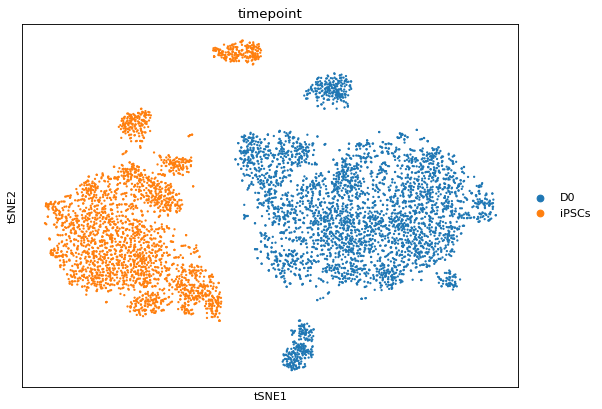

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8, 6), dpi=80)
dataset = all_data
sc.tl.tsne(dataset, use_rep='X_pca_harmony')
sc.pl.tsne(dataset, color='timepoint', ax=ax, show = False)
plt.show()

In [21]:
all_data.obs['timepoint']=='D0'

,dataset,timepoint,sample id,n_counts_all
AAACATACACTTTC-1_GSM2836267_D0._0,shiebinger,D0,0,7066.0
AAACATACCTTGGA-1_GSM2836267_D0._0,shiebinger,D0,0,4166.0
AAACATTGCTGTGA-1_GSM2836267_D0._0,shiebinger,D0,0,3970.0
AAACATTGGTTCGA-1_GSM2836267_D0._0,shiebinger,D0,0,2701.0
AAACATTGTCCTTA-1_GSM2836267_D0._0,shiebinger,D0,0,9687.0
...,...,...,...,...
TTTCGAACCGAATC-1_GSM2836284_iPSCs-2i._0,shiebinger,iPSCs,0,11480.0
TTTCTACTGGGATG-1_GSM2836284_iPSCs-2i._0,shiebinger,iPSCs,0,6179.0
TTTCTACTTACTGG-1_GSM2836284_iPSCs-2i._0,shiebinger,iPSCs,0,16405.0
TTTCTACTTATCGG-1_GSM2836284_iPSCs-2i._0,shiebinger,iPSCs,0,14032.0
